STD_AMOC= 4.168734178778184 STD_AMOC_noise= 4.906844548213673 AMOC length (timesteps): 365
Ensemble size:  2
Ensemble size:  3
Ensemble size:  4
Ensemble size:  5
Ensemble size:  10
Ensemble size:  20
Ensemble size:  50
Ensemble size:  100
Ensemble size:  1000


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


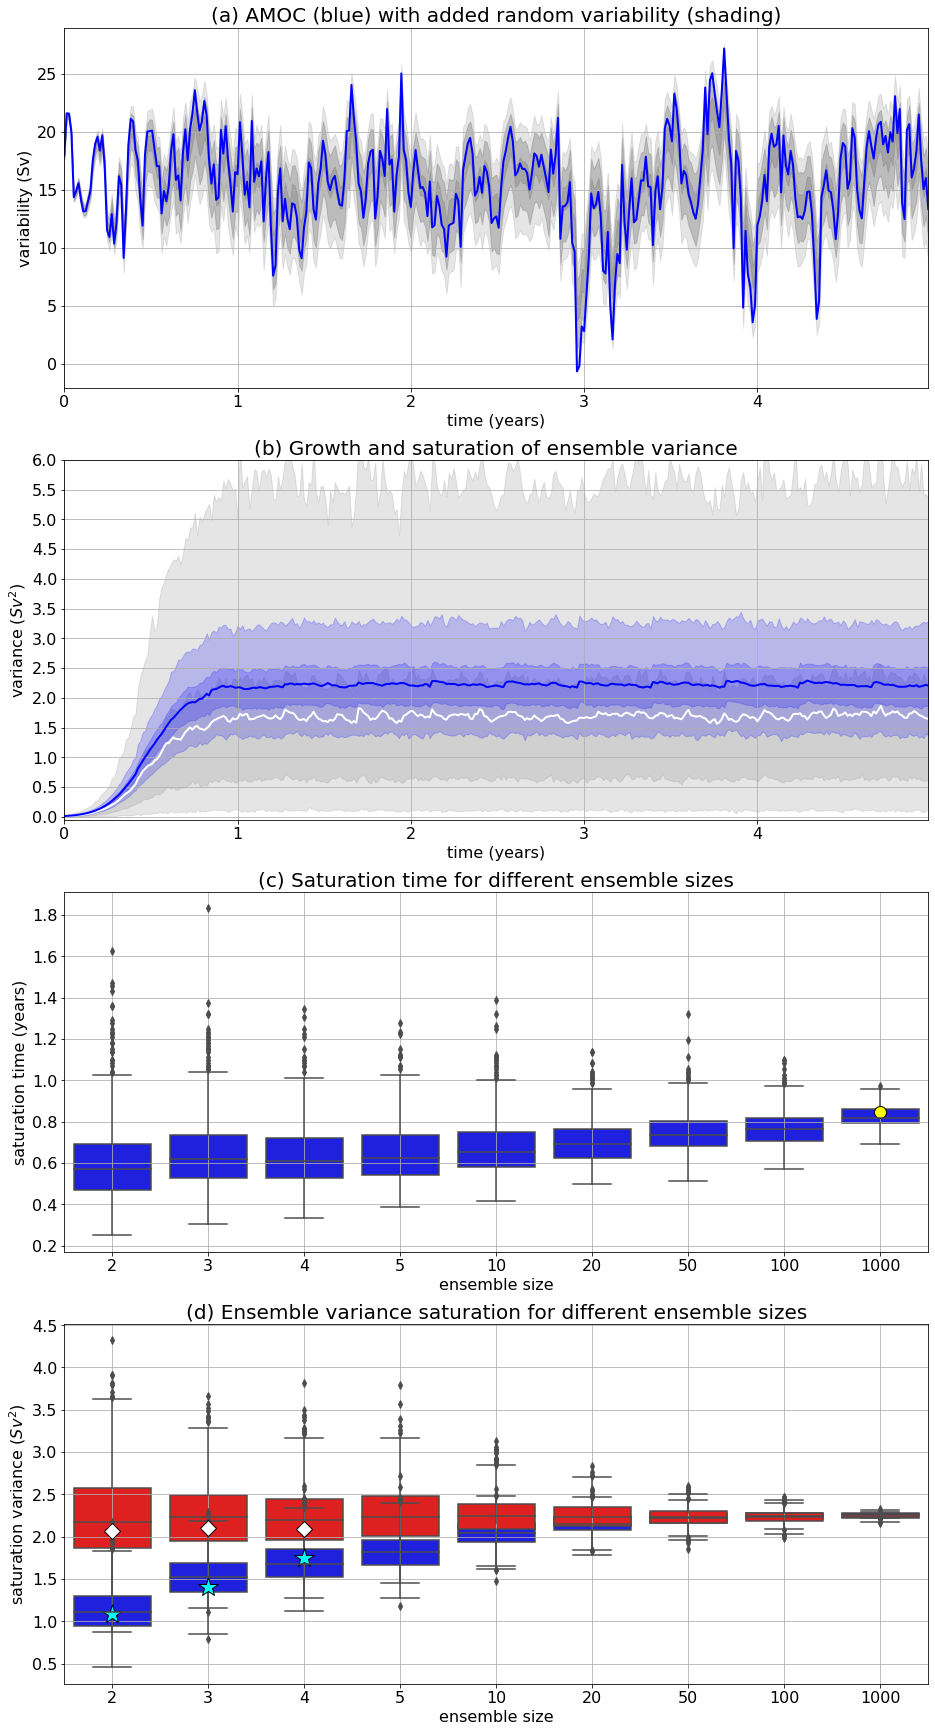

In [4]:
#-------------------------------------------------------------------------------------------
#
# Simple statistical model used to generate the data needed to 
# illustrate the impact of ensemble size on ensemble variance and saturation time
# of ensemble divergence shown in Figure A1 of
# 
# "Chaotic variability of the Atlantic meridional overturning
# circulation at sub-annual time scales"
#
# By Agathe Germe, Joel J.-M. Hirschi, Adam T. Blaker and Bablu Sinha
#
# The published figure is produced with nl = 1000 (see line 87). 
# For a quick test you may want to reduce that number e.g. nl = 10. 
#
#------------------------------------------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import seaborn as sns
import math

import xarray as xr
import pandas as pd
import copy
from pandas.plotting import autocorrelation_plot



#--------------------------------------------------
# Read in ORCA12 AMOC data:
#--------------------------------------------------
# Load some of the N12 ensemble AMOC data
dd='ENSEMBLE_ORCA12/N12_2007/N12_2007_01'
paths=f'{dd}/*.nc'
N1207 = xr.open_mfdataset(paths, combine='by_coords', parallel=False)
AMOC71 = N1207['MOCobs'][:,47,0,0] 
dd='ENSEMBLE_ORCA12/N12_2007/N12_2007_02'
paths=f'{dd}/*.nc'
N1207 = xr.open_mfdataset(paths, combine='by_coords', parallel=False)
AMOC72 = N1207['MOCobs'][:,47,0,0] 
dd='ENSEMBLE_ORCA12/N12_2007/N12_2007_03'
paths=f'{dd}/*.nc'
N1207 = xr.open_mfdataset(paths, combine='by_coords', parallel=False)
AMOC73 = N1207['MOCobs'][:,47,0,0] 

# Load some of the N12 ensemble AMOC data
dd='ENSEMBLE_ORCA12/N12_2009/N12_2009_01'
paths=f'{dd}/*.nc'
N1209 = xr.open_mfdataset(paths, combine='by_coords', parallel=False)
AMOC91 = N1209['MOCobs'][:,47,0,0] 
dd='ENSEMBLE_ORCA12/N12_2009/N12_2009_02'
paths=f'{dd}/*.nc'
N1209 = xr.open_mfdataset(paths, combine='by_coords', parallel=False)
AMOC92 = N1209['MOCobs'][:,47,0,0] 
dd='ENSEMBLE_ORCA12/N12_2009/N12_2009_03'
paths=f'{dd}/*.nc'
N1209 = xr.open_mfdataset(paths, combine='by_coords', parallel=False)
AMOC93 = N1209['MOCobs'][:,47,0,0] 

# Compute differences between ensemble to get estimate of sizes of chaotic/intrinsic variability:

AMOC7A = np.zeros([len(AMOC72),3])
AMOC7A[:,0] = (AMOC72-AMOC71)
AMOC7A[:,1] = (AMOC73-AMOC71)
AMOC7A[:,2] = (AMOC73-AMOC72)

#
AMOC9A = np.zeros([len(AMOC92),3])
AMOC9A[:,0] = (AMOC92-AMOC91)
AMOC9A[:,1] = (AMOC93-AMOC91)
AMOC9A[:,2] = (AMOC93-AMOC92)

AMOC = np.zeros([len(AMOC72),1])
AMOC[:,0] = AMOC73
MEAN_AMOC = np.mean(AMOC[:,0],0)

STD_AMOC = np.std(AMOC[:,0],0)


#------------------------------------------------------
# Beginning of statistical model to test ensemble sizes:
#------------------------------------------------------
# number of ensemble sizes to be tested:
nk = 9
# number of repeats for each ensemble size
nl =1000

# Number used for Germe et al. is nl =1000 (takes a while to compute so
# you may want to reduce this number)

# number of timesteps (arbitrary time units)
#nt = 1000
nt = len(AMOC)


ensemble_sizes = np.zeros((nk,1))
ensemble_sizes = [2,3,4,5,10,20,50,100, 1000]

#--------------------------------------------------
# Scale the noise to be added from 0 to 1 using 
# a sigmoid function (to mimic ensemble divergence)
#--------------------------------------------------

scale_noise = np.zeros((nt,1))

range_atan = 35
dt = range_atan/nt
start = -3.0

# Saturation time:
saturation_time_noise = (-np.log(1/9)-start)*5/range_atan
saturation_time_noise_squared = (-np.log(0.05409)-start)*5/range_atan

time_atan = start
time = np.zeros((nt,1))

for i in range(nt): 
    time[i] = i*5/365

for l in range(nt):
    time_atan = time_atan+dt
    scale_noise[l] = 1/(1 + math.exp(-time_atan))
    



#--------------------------------------------------------------------------
# delta: weight of low frequency vs high requency variability
# beta: weight of noise (high+low frequency) vs "predicable" variability
#--------------------------------------------------------------------------

#beta = 0.5
#delta= 0.3

beta = 1.0
delta = 0.4


#-------------------------------------------------------------------
# Define arrays containing the ensemble variances and 
# saturation times for each ensemble size 
#-------------------------------------------------------------------


c_var = np.zeros((nt,nl,nk))
c_saturation = np.zeros((nl,nk))
c_saturation_time = np.zeros((nl,nk))
diff1_var2 = np.zeros((nl,nk))

#-----------------------------------------------------------------------------------------------
# Define function to compute random walk using a sliding window of length N 
# rather than cumulating steps over the entire timeseries. This allows us to
# construct synthetic timeseries with properties that are close to what we see
# for the AMOC
#-----------------------------------------------------------------------------------------------

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N
N=7


#---------------------------------------------------------------------------
# Define function for block bootstrapping
#------------------------------------------------------------------------

def blockwise_subsampling(x,y,N1):
# Function which randomly subsamples a timeseries y (of length N3)  
# in blocks of length N1 (with replacement) to generate a synthetic 
# timeseries x of length N2 (needed for block bootstrapping)
 
    N2 = len(x)
    N3 = len(y)
    bootstrap = np.zeros((N2,1))
    iter = 0
    
    num_steps = int(N2/N1)
    
    for i in range(num_steps):        
        step_start = np.random.randint(0,N3-1)
        if step_start+N1 < N3-1:
            for j in range(step_start,step_start+N1):
                if iter < N2:
                    bootstrap[iter] = y[j] 
                    iter = iter + 1
        if step_start+N2 > N3-1:
            for j in range(step_start-N1,step_start):
                if iter < N2:
                    bootstrap[iter,0] = y[j] 
                    iter = iter + 1
    return(bootstrap[:,0])

# Concatenate differences between ensemble members (removing the first 50 timesteps
# in order remove the initial divergence phase between ensemble members)

icount = 0
len_concatenated = 3*(len(AMOC7A[:,1]) -50)
AMOC_concatenated = np.zeros((len_concatenated,1))
std_AMOC_noise = np.std(AMOC_concatenated[:,0])

for j in range(0,3):
    for i in range(50,364):
        AMOC_concatenated[icount] = AMOC7A[i,j]
        icount = icount+1
    
STD_AMOC_noise = np.var(AMOC_concatenated[:,0])

test = blockwise_subsampling(AMOC7A[:,0], AMOC_concatenated,31)    
    
print('STD_AMOC=',STD_AMOC, 'STD_AMOC_noise=',STD_AMOC_noise, 'AMOC length (timesteps):',nt)



#===================================================================
# Begin main loop over ensemble sizes:
#===================================================================
for k in range(nk):

    print('Ensemble size: ', ensemble_sizes[k])


# variables:
    n = ensemble_sizes[k]
    n1 = 3
    diff1_var = np.zeros((nl,n))


    
#=============================================
# Begin loop over number of repeats for each 
# ensemble size
#=============================================

    for l in range(nl):

#--------------------------------------------------
# Define arrays that need to be redefined for each
# ensemble size
#--------------------------------------------------
        B = np.zeros((nt,n))
        C = np.zeros((nt,n))
        

        diff1 = np.zeros((nt,n))
        
        noise = np.zeros((nt,n))


#==============================================================
# Construct noise to generate "ensemble" members
# The noise contains high and low frequency components to
# get a situation similar to what we have in the model where
# chaotic/intrinsic variability is found on short and long
# timescales
#
#==============================================================


        
#---------------------------------------------
# Computing synthetic timeseries with similar autocorrelation
# and variability amplitude but blockwise, random subsampling
# of the difference between ensemble members
#---------------------------------------------
        
        for j in range(n):
            B[:,j] = blockwise_subsampling(AMOC7A[:,0], AMOC_concatenated[:,0],31)  

            
#-------------------------    
# Add noise to "Control":
#-------------------------

        
        for j in range(n):
            beta = np.std(B[:,j],0)/np.std(AMOC[:,0],0)
            for i in range(nt):
 
                C[i,j] = (AMOC[i,0] -MEAN_AMOC + B[i,j]*scale_noise[i])/np.sqrt(1 + STD_AMOC_noise*scale_noise[i]/STD_AMOC) +MEAN_AMOC
    

#-----------------------------------------------------------------------------------
# Compute differences between random pairs of ensemble members (similar to approach
# used in Hirschi at al. 2013). 
#----------------------------------------------------------------------------------
                    
        for j in range(0,n):
            random_pair = np.random.choice(n,2,replace=False) 
            diff1[:,j] = (C[:,random_pair[0]] - C[:,random_pair[1]])/np.sqrt(2)
            diff1_var[l,j] = np.var(diff1[200:nt,j],0)    
  

#-----------------------------
# Compute ensemble variance:
#-----------------------------

        c_var[:,l,k] = np.var(C,1)

    
#------------------------------------------------
# Compute ensemble divergence saturation value
#------------------------------------------------

        c_saturation[l,k] = np.mean(c_var[200:nt,l,k])
#------------------------------------------------
# Compute saturation time for ensemble divergence
#------------------------------------------------
        saturation_count = 0
        smoothing_window = 3
        for i in range(smoothing_window,nt-smoothing_window):
            if (np.mean(c_var[i-smoothing_window:i,l,k],0) > 0.9*c_saturation[l,k]) and (saturation_count == 0):
                c_saturation_time[l,k] = i*5/360
                saturation_count = 1


    diff1_var2[:,k] = np.mean(diff1_var[:,:],1) 
            
            



#=================================================================================
#
# Compute ensemble divergences using Agathe's data so that these can be superposed
# on the values obtained with the statistical model
#
#=================================================================================

#---------------------------------------------
# Using same approach as Hirschi et al. 2013:
#---------------------------------------------

AMOC9A = np.zeros([len(AMOC92),6])
AMOC_diff_scaled = np.zeros([len(AMOC92),6])

AMOC9A[:,0] = (AMOC72[:len(AMOC92)]-AMOC71[:len(AMOC92)])
AMOC9A[:,1] = (AMOC73[:len(AMOC92)]-AMOC71[:len(AMOC92)])
AMOC9A[:,2] = (AMOC73[:len(AMOC92)]-AMOC72[:len(AMOC92)])
AMOC9A[:,3] = (AMOC92-AMOC91)
AMOC9A[:,4] = (AMOC93-AMOC91)
AMOC9A[:,5] = (AMOC93-AMOC92)

AMOC_diff_scaled = AMOC9A/np.sqrt(2)
AMOC_diff_var = np.var(AMOC_diff_scaled[50:,:],0)

# Randomly sample (with replacement) "ensembles" of sizes 2, 3 and 4 from AMOC_diff_var:

num_picks = 10

random_picks = np.zeros((num_picks,3))
for i in range(num_picks): 
        random_set = np.random.choice(5,2,replace=False)
        random_picks[i,0] =(AMOC_diff_var[random_set[0]] + AMOC_diff_var[random_set[1]])/2.0
        
        random_set = np.random.choice(5,3,replace=False)
        random_picks[i,1] =(AMOC_diff_var[random_set[0]] + AMOC_diff_var[random_set[1]] + 
                            AMOC_diff_var[random_set[2]])/3.0
    
        random_set = np.random.choice(5,4,replace=False)
        random_picks[i,2] =(AMOC_diff_var[random_set[0]] + AMOC_diff_var[random_set[1]] + 
                            AMOC_diff_var[random_set[2]] + AMOC_diff_var[random_set[3]])/4.0

                                          
#---------------------------------------------------------------------
# Using same approach as in this paper (and e.g. Leroux et al.l 2018):
#---------------------------------------------------------------------


AMOC1 = np.zeros([len(AMOC92),6])
AMOC1[:,0] = AMOC71[:len(AMOC92)]
AMOC1[:,1] = AMOC72[:len(AMOC92)]
AMOC1[:,2] = AMOC73[:len(AMOC92)]
AMOC1[:,3] = AMOC91
AMOC1[:,4] = AMOC92
AMOC1[:,5] = AMOC93


var_ensemble_size2 = np.zeros((len(AMOC92),4))
var_ensemble_size3 = np.zeros((len(AMOC92),2))
ensemble_size2_mean = np.zeros((4,1))
ensemble_size3_mean = np.zeros((2,1))


# ensemble size 2:
var_ensemble_size2[:,0] = np.var(AMOC1[:,:2],1)
var_ensemble_size2[:,1] = np.var(AMOC1[:,1:3],1)
var_ensemble_size2[:,2] = np.var(AMOC1[:,3:5],1)
var_ensemble_size2[:,3] = np.var(AMOC1[:,4:6],1)

ensemble_size2_mean = np.mean(var_ensemble_size2[50:,:],0)
ensemble_size2_mean2= np.mean(ensemble_size2_mean)

# ensemble size 3:
var_ensemble_size3[:,0] = np.var(AMOC1[:,:3],1)
var_ensemble_size3[:,1] = np.var(AMOC1[:,3:6],1)

ensemble_size3_mean = np.mean(var_ensemble_size3[50:,0],0)
ensemble_size3_mean2= np.mean(ensemble_size3_mean)



#===========================
# Begin Plot section:
#===========================

x025_3 = np.quantile(c_var[0:nt,:,2], .025, axis = 1, keepdims = True)
x25_3 = np.quantile(c_var[0:nt,:,2], .25, axis = 1, keepdims = True)
#x50_3 = np.quantile(c_var[0:nt,:,2], .5, axis = 1, keepdims = True)
x50_3 = np.mean(c_var[0:nt,:,2],1)
x75_3 = np.quantile(c_var[0:nt,:,2], .75, axis = 1, keepdims = True)
x975_3 = np.quantile(c_var[0:nt,:,2], .975, axis = 1, keepdims = True)

x025_100 = np.quantile(c_var[0:nt,:,6], .025, axis = 1, keepdims = True)
x25_100 = np.quantile(c_var[0:nt,:,6], .25, axis = 1, keepdims = True)
#x50_100 = np.quantile(c_var[0:nt,:,6], .5, axis = 1, keepdims = True)
x50_100 = np.mean(c_var[0:nt,:,6],1)
x75_100 = np.quantile(c_var[0:nt,:,6], .75, axis = 1, keepdims = True)
x975_100 = np.quantile(c_var[0:nt,:,6], .975, axis = 1, keepdims = True)

y001 = np.quantile(C[0:nt,:], .001, axis = 1, keepdims = True)
y025 = np.quantile(C[0:nt,:], .025, axis = 1, keepdims = True)
y25 = np.quantile(C[0:nt,:], .25, axis = 1, keepdims = True)
#y50 = np.quantile(C[0:nt,:], .5, axis = 1, keepdims = True)
y50 = np.mean(C[0:nt,:],1)
y75 = np.quantile(C[0:nt,:], .75, axis = 1, keepdims = True)
y975 = np.quantile(C[0:nt,:], .975, axis = 1, keepdims = True)
y999 = np.quantile(C[0:nt,:], .999, axis = 1, keepdims = True)


fig = plt.figure()
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rcParams["figure.figsize"]=(8,10)


plt.subplots_adjust(bottom=-0.3, top=2.0, left=0, right = 1.5)
ax1 = fig.add_subplot(411)
ax1.set_ylabel('variability (Sv)', fontsize = 16)
ax1.set_xlabel('time (years)', fontsize = 16)
ax1.set_title('(a) AMOC (blue) with added random variability (shading)', fontsize = 20)
plt.xlim(time[0],time[nt-1])


plt.fill_between(time[0:nt,0], y001[0:nt,0], y999[0:nt,0],facecolor='orange',color='grey',alpha=0.2)
plt.fill_between(time[0:nt,0], y025[0:nt,0], y975[0:nt,0],facecolor='orange',color='grey',alpha=0.4) 
plt.fill_between(time[0:nt,0], y25[0:nt,0], y75[0:nt,0],facecolor='orange',color='grey',alpha=0.4)

plt.plot(time[0:nt],AMOC[0:nt,0],color='b',linewidth=2)

plt.grid(True)



ax1 = fig.add_subplot(412)
ax1.set_ylabel('variance ($Sv^2$)',fontsize=16)
ax1.set_xlabel('time (years)',fontsize=16)
ax1.set_title('(b) Growth and saturation of ensemble variance', fontsize = 20)


plt.yticks((0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5,4.0,4.5,5.0,5.5,6))
plt.ylim(-0.05,6)
plt.xlim(time[0],time[nt-1])

plt.grid(True)

plt.fill_between(time[0:nt,0], x025_3[0:nt,0], x975_3[0:nt,0],facecolor='orange',color='grey',alpha=0.2) 
plt.fill_between(time[0:nt,0], x25_3[0:nt,0], x75_3[0:nt,0],facecolor='orange',color='grey',alpha=0.2)


plt.fill_between(time[0:nt,0], x025_100[0:nt,0], x975_100[0:nt,0],facecolor='orange',color='blue',alpha=0.2) 
plt.fill_between(time[0:nt,0], x25_100[0:nt,0], x75_100[0:nt,0],facecolor='orange',color='blue',alpha=0.2)

plt.plot(time[0:nt],x50_3,color='white',linewidth=2)
plt.plot(time[0:nt],x50_100,color='blue',linewidth=2)



ax1 = fig.add_subplot(413)
ax1.set_ylabel('saturation time (years)',fontsize=16)
ax1.set_xlabel('ensemble size', fontsize=16)
ax1.set_title('(c) Saturation time for different ensemble sizes', fontsize = 20)



ax = sns.boxplot(data =[c_saturation_time[:,0],c_saturation_time[:,1],c_saturation_time[:,2],c_saturation_time[:,3],
                        c_saturation_time[:,4],c_saturation_time[:,5],c_saturation_time[:,6],c_saturation_time[:,7],
                        c_saturation_time[:,8]],color='blue')
ax.set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=ensemble_sizes[:])

ax1.plot(8, saturation_time_noise_squared, color='yellow', marker='o', markeredgecolor='k',markersize=12)


plt.grid(True)


ax1 = fig.add_subplot(414)
ax1.set_ylabel('saturation variance ($Sv^2$)',fontsize=16)
ax1.set_xlabel('ensemble size',fontsize=16)
ax1.set_title('(d) Ensemble variance saturation for different ensemble sizes', fontsize = 20)




ax = sns.boxplot(data =[c_saturation[:,0],c_saturation[:,1],c_saturation[:,2],c_saturation[:,3],c_saturation[:,4],
                        c_saturation[:,5],c_saturation[:,6], c_saturation[:,7],c_saturation[:,8]], color='blue')
ax.set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=ensemble_sizes[:])

ax = sns.boxplot(data =[diff1_var2[:,0],diff1_var2[:,1],diff1_var2[:,2],diff1_var2[:,3],diff1_var2[:,4],
                        diff1_var2[:,5],diff1_var2[:,6],diff1_var2[:,7],diff1_var2[:,8]], color='red')
ax.set(xticks=[0,1,2,3,4,5,6,7,8], xticklabels=ensemble_sizes[:])


ax1.plot(0, ensemble_size2_mean2, color='cyan', marker='*', markeredgecolor='k',markersize=20)
ax1.plot(1, ensemble_size3_mean2, color='cyan', marker='*', markeredgecolor='k',markersize=20)
ax1.plot(2, 1.75, color='cyan', marker='*', markeredgecolor='k',markersize=20)

ax1.plot(0, np.mean(random_picks[:,0],0), color='white', marker='D', markeredgecolor='k',markersize=12)
ax1.plot(1, np.mean(random_picks[:,1],0), color='white', marker='D', markeredgecolor='k',markersize=12)
ax1.plot(2, np.mean(random_picks[:,2],0), color='white', marker='D', markeredgecolor='k',markersize=12)

plt.grid(True)






# Save figure:
plt.savefig('../figures/test_ensemble_divergence_figure_A1.png',dpi=400, bbox_inches='tight' )
plt.savefig('../figures/test_ensemble_divergence_figrue_A1.eps',format='eps')

plt.show()


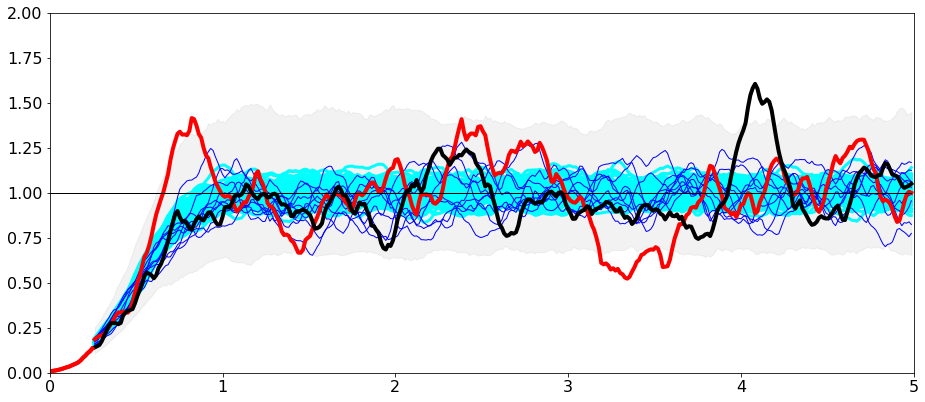

In [6]:
#-------------------------------------------------------------------
# Code to generate Figure A2 from 
# 
# "Chaotic variability of the Atlantic meridional overturning circulation at
# subannual timescales"
#
# By Agathe Germe, Joel J.-M. Hirschi, Adam T. Blaker and Bablu Sinha
#
# JH 26/01/2022
#---------------------------------------------------------------------

nt =365
nt2 = 365
window = 19

from scipy.signal import savgol_filter
yhat = np.zeros((nt,nl,3))
yhat_scaled = np.zeros((nt,nl,3))

#for i in range(nl):
#    yhat[:,i,0] = savgol_filter(np.sqrt(c_var[0:nt,i,2]), 71, 5) # window size 51, polynomial order 3
#    yhat[:,i,1] = savgol_filter(np.sqrt(c_var[0:nt,i,4]), 71, 5) # window size 51, polynomial order 3
#    yhat[:,i,2] = savgol_filter(np.sqrt(c_var[0:nt,i,6]), 71, 5) # window size 51, polynomial order 3
    
for i in range(nl):
    yhat[:nt-window+1,i,0] = running_mean(np.sqrt(c_var[0:nt,i,2]), window) # 3-month running mean
    yhat[:nt-window+1,i,1] = running_mean(np.sqrt(c_var[0:nt,i,4]), window) # 3-month running mean 
    yhat[:nt-window+1,i,2] = running_mean(np.sqrt(c_var[0:nt,i,6]), window) # 3-month running mean


for j in range(nl):
    yhat_scaled[:nt,j,0] = yhat[:,j,0]/np.mean(yhat[150:nt-window,j,0],0)
    yhat_scaled[:nt,j,1] = yhat[:,j,1]/np.mean(yhat[150:nt-window,j,1],0)
    yhat_scaled[:,j,2] = yhat[:,j,2]/np.mean(yhat[150:nt-window,j,2],0)
    
# Compute percentiles:
# Ensemble size 4:
a025_1000 = np.quantile(yhat_scaled[:,:,0], .025, axis = 1, keepdims = True)
z25_1000 = np.quantile(yhat_scaled[:,:,0], .25, axis = 1, keepdims = True)
z50_1000 = np.mean(yhat_scaled[:,:,0],1)
z75_1000 = np.quantile(yhat_scaled[:,:,0], .75, axis = 1, keepdims = True)
a975_1000 = np.quantile(yhat_scaled[:,:,0], .975, axis = 1, keepdims = True)

# Ensemble size 10:
a025_1000_10 = np.quantile(yhat_scaled[:,:,1], .025, axis = 1, keepdims = True)
z25_1000_10 = np.quantile(yhat_scaled[:,:,1], .25, axis = 1, keepdims = True)
z50_1000_10 = np.mean(yhat_scaled[:,:,1],1)
z75_1000_10 = np.quantile(yhat_scaled[:,:,1], .75, axis = 1, keepdims = True)
a975_1000_10 = np.quantile(yhat_scaled[:,:,1], .975, axis = 1, keepdims = True)

# Ensemble size 50:
a025_1000_50 = np.quantile(yhat_scaled[:,:,2], .025, axis = 1, keepdims = True)
z25_1000_50 = np.quantile(yhat_scaled[:,:,2], .25, axis = 1, keepdims = True)
z50_1000_50 = np.mean(yhat_scaled[:,:,2],1)
z75_1000_50 = np.quantile(yhat_scaled[:,:,2], .75, axis = 1, keepdims = True)
a975_1000_50 = np.quantile(yhat_scaled[:,:,2], .975, axis = 1, keepdims = True)


    
fig = plt.figure()
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.rcParams["figure.figsize"]=(8,10)


plt.subplot(411)
plt.subplots_adjust(bottom=-0.3, top=2.0, left=0, right = 1.5)
#ax1 = fig.add_subplot(411)
ax1.set_ylabel('normalised standard deviation', fontsize = 16)
ax1.set_xlabel('time (years)', fontsize = 16)
#ax1.set_title('Ensemble standard deviation', fontsize = 20)
#xmarks = range(0, int(time, 20)
#plt.xticks(xmarks, " ")

plt.xlim(0,5)

#plt.ylim(-0.2,2)
plt.ylim(0,2)


plt.plot(time[0:window,0], np.mean(c_var[0:window,:,1],1), color='red',linewidth=4)      
plt.fill_between(time[window:nt,0], a025_1000[0:nt-window,0], a975_1000[0:nt-window,0],facecolor='orange',color='grey',alpha=0.1) 

#plt.fill_between(time[25:nt,0], a025_1000_10[25:nt,0], a975_1000_10[25:nt,0],facecolor='orange',color='grey',alpha=0.1) 
 
#plt.fill_between(time[25:nt,0], a025_1000_50[25:nt,0], a975_1000_50[25:nt,0],facecolor='orange',color='grey',alpha=0.1) 
 




for j in range(0,99):  
    plt.plot(time[window:nt],yhat_scaled[0:nt-window,j,2],color='cyan',linewidth=3,alpha=1)

for j in range(90,99):    
    plt.plot(time[window:nt],yhat_scaled[0:nt-window,j,1],color='blue',linewidth=1,alpha=1)
#    plt.plot(time[:nt2],yhat_scaled[:nt2,j,2],color='blue',linewidth=1,alpha=1)    

plt.plot(time[window:nt],yhat_scaled[0:nt-window,704,0],color='red',linewidth=4,alpha=1.0)
#plt.plot(time[:nt2],yhat_scaled[:nt2,704,1],color='red',linewidth=4,alpha=1.0)
#plt.plot(time[:nt2],yhat_scaled[:nt2,704,2],color='red',linewidth=4,alpha=1.0)

   
for j in range(92,93):
    plt.plot(time[window:nt],yhat_scaled[0:nt-window,j,0],color='black',linewidth=4,alpha=1)  
#    plt.plot(time[0:nt2],yhat_scaled[0:nt2,j,1],color='black',linewidth=4,alpha=1)  
#    plt.plot(time[0:nt2],yhat_scaled[0:nt2,j,2],color='black',linewidth=4,alpha=1)     

plt.plot(time[0:nt],c_var[0:nt,1,0]*0 +1,color='black',linewidth=1,alpha=1)
plt.plot(time[0:window,0], np.mean(c_var[0:window,:,1],1), color='red',linewidth=4)


#plt.plot(time[0:nt2],np.sqrt(c_var[0:nt,0,4]),color='red',linewidth=1,alpha=1)
#plt.plot(time[0:nt],np.sqrt(c_var[0:nt,0,8]),color='black',linewidth=2,alpha=1)

# Save figure:
plt.savefig('../figures/test_ensemble_divergence_figure_A2.png',dpi=400, bbox_inches='tight' )


